# Exercise 4 [Cart-Pole Model]

In [4]:
# a few packages we need to import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython

# Problem
We are interested in computing a linear optimal control law to stabilize the cart pole system when subjected to small
deviations from the rest position (when $x=0$, $v=0$, $\theta = \pi$ and $\omega = 0$)

<img src="cart_pole.png" alt="drawing" width="400"/>

The dynamic equations of the Cart-Pole model are written as
$$\begin{eqnarray} \dot{x} &=& v \\ 
\dot{v} &=& \frac{f + m_p \sin\theta (l \omega^2 + g \cos \theta)}{m_c + m_p \sin^2 \theta} \\
\dot{\theta} &=& \omega \\
\dot{\omega} &=& \frac{-f\cos\theta -m_p l \omega^2 \cos\theta\sin\theta - (m_c + m_p)g \sin\theta}{l(m_c + m_p \sin^2 \theta)}
\end{eqnarray}$$

which we discretize using a time step $\Delta t$
$$ \begin{eqnarray} 
x_{n+1} &=& x_n + \Delta t\cdot v_n \\ 
v_{n+1} &=& v_n + \Delta t \cdot \left( \frac{f_n + m_p \sin\theta_n (l \omega_n^2 + g \cos \theta_n)}{m_c + m_p \sin^2 \theta_n} \right)\\
\theta_{n+1} &=& \theta_n + \Delta t \cdot \omega_n \\
\omega_{n+1} &=& \omega_n + \Delta t \cdot \left( \frac{-f_n\cos\theta_n -m_p l \omega_n^2 \cos\theta_n\sin\theta_n - (m_c + m_p)g \sin\theta_n}{l(m_c + m_p \sin^2 \theta_n)}\right)
\end{eqnarray}$$

This is the equations we use to simulate the dynamics of the system below

## Simulation of the Cart-Pole model and display functions

In [5]:
def simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81):
    """
    This function integrates the cart-pole system (the nonlinear system) for horizon_length steps
    
    Arguments:
    x0: numpy vector, initial value for the system (4 numbers for x,v,theta,omega)
    K: a list of control gains (of length horizon_length)
    uff: a list of feedforward control inputs such that the control will be f[i]=K[i] * x[i] + uff[i]
    horizon_length: lenght of the horizon to integrate
    
    Returns:
    x a numpy array containing the integration result
    u a numpy array containing the control at each step
    """
    delta_t = 0.01
        
    x=np.empty([4, horizon_length+1])
    x[:,0] = x0
    
    x_star = np.array([0, 0, np.pi, 0])

    u=np.empty([horizon_length])

    for i in range(horizon_length):
        uff[i] = np.dot(K[i], x_star)
        u[i] = K[i].dot(x[:,i]) - uff[i]
        dx = np.array([x[1,i],
                      (u[i] + mp*np.sin(x[2,i])*(l*(x[3,i]**2) + g * np.cos(x[2,i])))/(mc+mp*np.sin(x[2,i])**2),
                      x[3,i],
                      (-u[i]*np.cos(x[2,i])-mp*l*(x[3,i]**2)*np.cos(x[2,i])*np.sin(x[2,i])-(mp+mc)*g*np.sin([x[2,i]]))/(l*(mc+mp*np.sin(x[2,i])**2))
                       ])
        x[:,i+1] = x[:,i] + delta_t * dx
    return x, u

In [6]:
def animate_cart_pole(x):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation
    """
    
    #subsample
    plotx = x[:,0::5]
    
    
    fig = matplotlib.figure.Figure(figsize=[6,2.3])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-3,3], ylim=[-1.,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[2,i])
        y_pend = cart_height - np.cos(plotx[2,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=50, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

# Question 1
Linearize the discretized equations of the Cart-Pole Model around the resting position $\bar{x}=0$, $\bar{v}=0$, $\bar{\theta}=\pi$ and $\bar{\omega}=0$, $\bar{f}=0$ and write the dynamic equations in the form 

$$ \begin{bmatrix} \tilde{x}_{n+1} \\ \tilde{v}_{n+1} \\ \tilde{\theta}_{n+1} \\ \tilde{\omega}_{n+1} \end{bmatrix} = A \begin{bmatrix} \tilde{x}_{n} \\ \tilde{v}_{n} \\ \tilde{\theta}_{n} \\ \tilde{\omega}_{n} \end{bmatrix} + B \tilde{f}_n$$

where $A$ and $B$ are matrices of appropriate size and $\tilde{x}_n = x_n - \bar{x}$, $\tilde{v}_n = v_n - \bar{v}$, $\tilde{\theta}_n = \theta_n - \bar{\theta}$, $\tilde{\omega}_n = \omega_n - \bar{\omega}$ and $\tilde{f}_n = f_n - \bar{f}$. Remember that the resting position is a fixed point, i.e.

$$ \begin{bmatrix} \bar{x} \\ \bar{v} \\ \bar{\theta} \\ \bar{\omega} \end{bmatrix} = f(\bar{x}, \bar{v}, \bar{\theta}, \bar{\omega},  \bar{f})$$
where $f$ is the discretized dynamic equation of the Cart-Pole Model

# Question 2
We would like to use the linearized equation to compute an optimal controller that stabilizes the system around the resting position. 
1. Write a cost function that will help stabilize the resting position (be precise with the variables you use).
2. How would you (approximately) solve this optimal control problem?
3. What will be the form of the optimal controller $f_n$ (remember that the linearized system will give you $\tilde{f}_n$)?

# Question 3
1. Write a function (e.g. take example from Exercise 3) that computes the optimal control for the linearized problem. 2. Simulate the dynamics of the Cart-Pole Model with the computed controller for initial conditions $x=0.2$, $v=0.1$, $\theta=\pi-0.2$ and $\omega=0$. What happens? (show a plot of the states of the system and the cart-pole animation)
3. How can you change the response of the  system (how fast it stabilizes)? Give an example with a simulation.
4. Does the controller still work when $x=0.2$, $v=0.1$, $\theta=0.2$ and $\omega=0$? Why? (show a plot of the states of the system and the cart-pole animation, use a smaller horizon if necessary)

###  Below is the sumulation with $x=0.2$, $v=0.1$, $\theta=\pi-0.2$ and $\omega=0$.

<IPython.core.display.Javascript object>


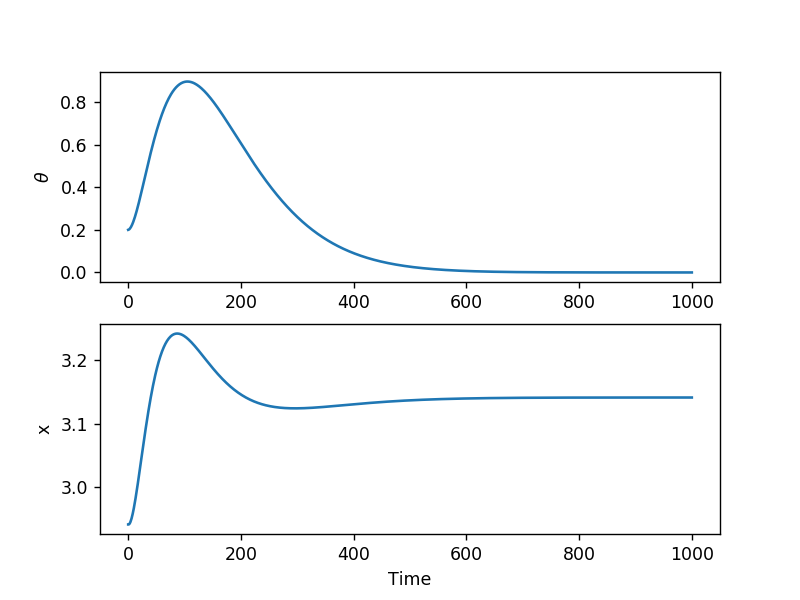

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAADnb21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTAxIDdkMGZmMjIgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxFZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZeefjq238wC8Oa/sGes+coyk
2qd8HxFfO7nZwwnIfLxe1pPavqHLwyVH0m6V/ceQDUBOlZFdpHt1IRdC5RR/VgqGyJwnC9G8QJHx
VhglwZsh19ZfRb5DCeRKm5GN9CcqRIs9liZITw68YU5TbD2HKwoAcxqO8ZvLGHx1ovpTZUGJZ2hi
vmK+8mtBtIaQUn7FvLnYSNUXYiiX7UcDdnjgK1wx7u04tYJo7I17j7HLLtBil0Hfov3c8b5Zldf5
Np7kkONvWGr1YmMkXQVExLlDVYq3TQFlgm+SJbK3J/UlJK+30fqIfGbPL687XlGeSn1TY7bYN5SK
nVBVGlUcxlSPZYY/Rxe/bG33YxCMvMDoPaBKJtWD9OYcnYYoia8UnYEtsLXkB2uo6PK9o617NtMh
ItSSD07hi6pvGVkZHQXx9CDvG0BVm9RSeUxpNT+a5bC4M8mn8sZz7uEqxV1PqpOwuuSwpS7FyucP
tckmMcceR8VBD0jOucUcxtqqPCtYSOLxDdl2hV7FvkD0eJZ+tL/l/kvnCDVtR6sUw6vV19+433r/
SXb6LBEW3AzGP5M+Qs8TpGF+3UQv9kuQF+1sAJ98Pc2B8/8CtgcLttbib9vhLZyrWMZHs4RrRzA3
abZXu1Rgfz3PNRup6cacnp4Q4CUZkGX7Enc7pg3+G3LaAv5fHcJ09sbJvazqPtTycsXpUZ9w7Uam
JFr2rPhB362qcLMwoskij4r/UpBAFPFxCexX+dcDP0bDelgPGVVLZD1gLNG3dSFVN+4U+sP1KLpf
hBFzduurILgHSHiE8e3cAaFB0icTZDLkiyIfC4LdI9fw7/WkOyAVqawHRg+kZ4uZhAmkP7Pt7BPu
jSA6qRllzpw/BSBR4P4FQflzb+MeWmXrtfVzG781LvqlHy0h/AcolTGIfN3tunY0bBPOB7BbGbrR
D+n0xpt+EqccPLrBIf5tu4ajeQDWmyWsWgB9obPn8HkTO2Wn0X+DuABD4SWSr0aCDmsKzzmO6/Cw
Qe7itQo8InB61BjOZnmzlsRttB+HDZaHFquKSu+H2svaIrm1j786XOXQk7yYcJtxb1fdS9cGxKsz
VT8WZyukkdeXjrEP8OmsPpd/X5/qJwZ0ArKR/PlnBBwIHzQztOw/5rcUuPjGOVG7pJ2KgtX6hxO3
m/6a7s5/zTpml5p4l6JOjzF8Rn/xujuYlQDSPXWrEIsNGX9AOnov5q5P4xCbVK2QU8xtYLr0Unkp
zAmOSn78M971GNSZE2F8z9ojNd4p1zQvEDxb6KpMbZURYQLI7i/atH5EzZ5KVbT1KLH/85UKDh6M
4bhYvke818lzSBNxvjVoIXvyPo8fogkMQ1cOBPUp+xjxBCWqkiyAn2+eHiT3IudX+7cC/MFpmMFg
yneq1N5gAARxnARm/OjGt6MznPJJteYZWkrc5pQaxl0iG990vSscM+1ZKsfoVIdAdaW4J2mqoHCq
8RtFQoJAnD6UYLxF8DdbnzQS2nNhOs3RgjZyazVG/z3Ok68C4ZfiFReywSvHJymDBy4Nks0dJZHU
4F0Kw1sNRvujhBCcf2WD2rWylf0hsmi3VzL40DP3HHx+TcmlsoKwu9Ce7pD4gipIIEI9WqCh3J63
4mtkoBI4qOhnt3bfJptFtsnsnPicAe7BPtK5Xc9HAwqF3WOI++cfkhHBgqAzLl2NMgGgwRcQHNcd
5p3fpUia742g+CCyaw3OCEIuP+EK8GcOjqMmJ8DfM9qbzP6WKsBN//r3xJxeCM2yiXSwLz8hZOkz
2uqsHnZb5HMfB+Y5P9j3DbBfvsOaGwKB7+mOPhvdYuh9LVUNcXc8hw2dJzgr7bT1ZH8zsFvKFHdd
C1S9vQI7QOeA14q2LkH/B/p2KXqFPaopkFLeci+gB0F035f4eElMQ/mQ6hyvX7y3ioINDJYiOw74
VHzwKGD+ymW2Fy5makGYze2ddqrhwPZDr1qBl8GfqCYcnIZFCdFlAuRm7zaA+gODB7Xx+wbNz7Fz
E6NRnyrVd6INIpNB5GWf6+DP6Jmd1O0gUC/6bBuk8PH8lFMgMb1yJ+LrRiKFIYa8IWPmEVpQMwpW
XN3yiHQzNDHL7DaS3YcO5i9/AHlv0Sbz2+FlkYEDKvW54VkuON5d4KkwEVaXZnSetHfTDMiuk5tx
HZlGlzJsFaTDrgyRg2jmeqhgalHiHXfkwMKGZqnTFThafJLXgAMJ9T1+gwPS52fOjCmGd2ROsffP
svz6844Dc1WHfkm3VNGWtnlWpDN6RPyxWnl09v2lfMnRK/FjrcpMyJNI7UB1rIZAl/2cl6z31cCt
9hSXsUaTZER/iC4+d9LwV4yeWhZ7fsnmZsMybmytpS1ESa9eMgSFfZvBOpgeiIRnRydbsxhv0JPI
RV7FM/0Q+ZqTCB4PMb4t1wbkrEUW57zM1BdAc8zsubC2siwKU3rGVZsdfvCTw3+Zboxd7asos965
M+Y8o5IZIWc/C80xkRTd6qmVLEWvUzfwNK9a4XtOyiaoQ7wA3wOxWhbYd3bgZpdMf+Y+8hHDEMfH
ROQ2bi5En+wdLYwrUCEbUWEBU9Oif1qF5ybJ/kUZNKPlX5Q3YaOwX0pBYYYPsHRwVQ+kYNPwAlXd
78IitHBHYX8f/YUH1Kqnbgc1lHBggFZBfUKQpXjZH6FS6CxYSiR1MkdRCbtoXoy298cjt1ODOL1n
Y2nUKrnZp6HhfkkNhkKemqm73xabo7a/fubiEYYcR+Ahll0XPiAADcoqLbCXCoJ9LiWKQXggAP/S
phMjLTpAra3zisJUafNUGc5CGA42a+IfTutUl20nabdRc65CiFeo1o8gYcO4VrGZFmxlXpaOwkGZ
eL6p9Obew4Ji1G5S+G6Ks

In [7]:
def solve_ricatti_equations(A,B,Q,R,horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min xQx + sum(xQx + uRu) subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from N to 0
    K: list of numpy arrays containing Kn from N-1 to 0
    """
    P = [] #will contain the list of Ps from N to 0
    K = [] #will contain the list of Ks from N-1 to 0

    
    #################################################
    #### THIS IS WERE YOU NEED TO FILL YOUR CODE ####
    #################################################
    N = horizon_length
    PN = Q
    P.append(PN)
   
    for i in range(N):
        
        Kn = np.dot(-np.linalg.inv(R + np.matmul(np.dot(B.T,P[i]), B)), np.dot(B.T, np.matmul(P[i], A)))
        K.append(Kn)
        
        Pn = Q + np.matmul(A.T, np.matmul(P[i], A)) + np.matmul(A.T, np.matmul(P[i], np.dot(B, K[i])))
        P.append(Pn)
    
    return P[::-1],K[::-1]

# we simulate the system
horizon_length =1000
uff = [0.]
uff = uff*horizon_length
mp=1.
mc=5.
l=1.
g=9.81
delta_t = 0.01
x0 = np.array([0.2, 0.1, np.pi-0.2, 0.])


A = np.array([[1, delta_t, 0 , 0], [0, 1, delta_t*(mp*g)/mc, 0], [0, 0, 1, delta_t], [0, 0, delta_t*(mc + mp)*g/(l*mc), 1]])
B = np.array([[0] ,[delta_t*(1/mc)], [0], [delta_t*(1/(l*mc))]])
Q = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
R = np.array([0.01])

P, K = solve_ricatti_equations(A, B, Q, R, horizon_length)

x,u = simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81)

# plot x and theta as a function of time
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[0,:])
plt.ylabel(r'$\theta$')
plt.subplot(2,1,2)
plt.plot(x[2,:])
plt.ylabel('x')
plt.xlabel('Time')

# make an animation of the cart-pole
animate_cart_pole(x)

## How can you change the response of the system (how fast it stabilizes)? Give an example with a simulation.

## Answer: We can change the response of the system by giving weights to the state in the Q matrix and R matrix. For e.g I took 
$$ Q = \begin{bmatrix} 1000 & 0 & 0 & 0 \\ 0 & 10 & 0 & 0 \\ 0 & 0 & 1000 & 0 \\ 0 & 0 & 0 & 10 \end{bmatrix}$$
$$ R = [0.0001] $$

In [ ]:
def solve_ricatti_equations(A,B,Q,R,horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min xQx + sum(xQx + uRu) subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from N to 0
    K: list of numpy arrays containing Kn from N-1 to 0
    """
    P = [] #will contain the list of Ps from N to 0
    K = [] #will contain the list of Ks from N-1 to 0

    
    #################################################
    #### THIS IS WERE YOU NEED TO FILL YOUR CODE ####
    #################################################
    N = horizon_length
    PN = Q
    P.append(PN)
   
    for i in range(N):
        
        Kn = np.dot(-np.linalg.inv(R + np.matmul(np.dot(B.T,P[i]), B)), np.dot(B.T, np.matmul(P[i], A)))
        K.append(Kn)
        
        Pn = Q + np.matmul(A.T, np.matmul(P[i], A)) + np.matmul(A.T, np.matmul(P[i], np.dot(B, K[i])))
        P.append(Pn)
    
    return P[::-1],K[::-1]

# we simulate the system
horizon_length =1000
uff = [0.]
uff = uff*horizon_length
mp=1.
mc=5.
l=1.
g=9.81
delta_t = 0.001
x0 = np.array([0.2, 0.1, np.pi-0.3, 0.])
# x0 = np.array([0.2, 0.1, 0.2, 0.])

A = np.array([[1, delta_t, 0 , 0], [0, 1, delta_t*(mp*g)/mc, 0], [0, 0, 1, delta_t], [0, 0, delta_t*(mc + mp)*g/(l*mc), 1]])
B = np.array([[0] ,[delta_t*(1/mc)], [0], [delta_t*(1/(l*mc))]])
Q = np.array([[1000, 0, 0, 0], [0, 10, 0, 0], [0, 0, 1000, 0], [0, 0, 0, 10]])
R = np.array([0.0001])

P, K = solve_ricatti_equations(A, B, Q, R, horizon_length)

x,u = simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81)

# plot x and theta as a function of time
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[0,:])
plt.ylabel(r'$\theta$')
plt.subplot(2,1,2)
plt.plot(x[2,:])
plt.ylabel('x')
plt.xlabel('Time')

# make an animation of the cart-pole
animate_cart_pole(x)

<IPython.core.display.Javascript object>

### Simulation with $x=0.2$, $v=0.1$, $\theta=0.2$ and $\omega=0$ with horizon length 100

C:\Users\kamal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
C:\Users\kamal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
C:\Users\kamal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kamal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kamal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sin
C:\Users\kamal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in cos
C:\Users\kamal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: inval

<IPython.core.display.Javascript object>


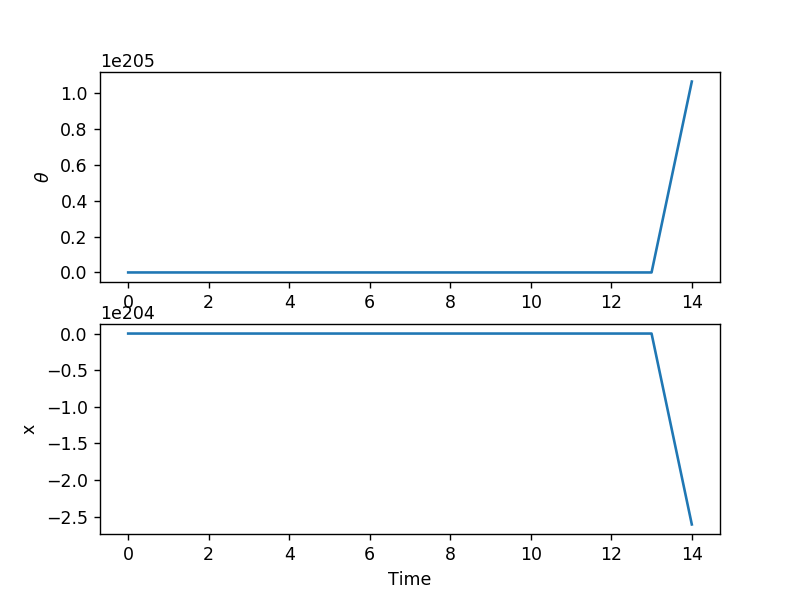

C:\Users\kamal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sin
C:\Users\kamal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in cos


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAP621kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTAxIDdkMGZmMjIgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAsYZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZeefjq238wBllI30PNlJSNeQ
G10PqaJ6DwadMphNjMapwKorDtUZVUFjPYUr04ztHE/tq/wbLS1L9009d4m/8DFbY/lIa58b3xws
8pUfPbXZttW0KiU3rY2zg/daDZGPAxStVqbcfIdv0sYsPvJd1ZYFfPrfuTwhhq7hrrWlfZ9vVkhu
zwKcSmu4SxwM9T3uPSBFY9ME2uryGb+nvOgxF2T71oaYYJiqdrZnblpNDWxFw0I3MgZluosm5SL+
ESFzhXnSpwpxSKkNnf50we0hyZT+hNaCIC+6D5P/LIhYASOBw6HyzBlsap9RBTj+7BNBkeEL3195
7KRRc8COIJ5jz1daF8Eg6JsvOxyW6+wMLkDhZY9GOarpQ4pgBhJP08DT0egNtdV59pS3kp7QT5mM
NnfqrBtb8XcVBs3NgehO1FEtPprnN/ZtW+KUJSGeVJ8PYegn8QxyirpSx8SFTxHbUM9AnYighbvx
lC062YHBXhfJN/p4SodIaDml/W91IHNh4mB04DXVMJ70yM17s8Ysz5YlEO8wxxY1wtEoIi53Wd+Z
cIjwPUJL6z12PBiNf5sHpsGKXrHQpZAnr8TCs6/Drh+2uZu5OcOsO+oGh7mjjtji9TIDuPDAvDQo
tYiZZUBnxUV9Cqx9ioNbvVxLLD0feBp+7DglbdUinM5pAghck9QV+c2W37iml0RyNCbnN1wSs4uo
MGFyjAWOe8aGg6ErwL31UWIm9VPtkJa0B/QeewLDdGz2d7va2H7cjkRGLm4XjERGombnBwT/Y+AN
NqQ2a1H0bkbaFkNF1H5+KzMIHzKA4UqAooDTKoLgjlj7ysBmDm+u3YdXlcoxpVweiUykybyw3/EN
dkfWM3/igbFkV2h42rmpPa05sWyHVAectSeHVthPcLlwMYdL7+/S6KpnQ/l8SGvlLdNo6Hk1Jn1v
zow0kruSNhx/Xaab2OJDrSYVJhve5o7tTEnpXxVUle6YT/w2LgZ5/5lCQph0mboFvUs2+Pnn36Oh
AdWtAzeGsjTVBrkdUPW+eBxJkwxwPSyqvaWUOgDLM1kiFuj1/w89M5/+f763jHMYeHT4MtF6KH+F
NhLhmGyEwyM+vq58UkkUD6BR3EzL70gTulJuavj0SQhmAhXapZqB0BDqhDqV81yJac4sX4irsa/G
FokIaH0pMtIxzvgyEB0H0Kf2BUo2INkXZP5Su3qKwE3pypXBcRgNjV9vw39n9ZZ0RVFHfLNgBeXX
XxmQGSzbe54S2vcxrag7dSOsoFSlOklLyBCVTnn3G+dgM+cAsNeRb/z1q7/bzAFmqzPgN/Aem7bY
QOc1KXcAlDw3MWH0SA/sNEiZqRcwOd34neL98GzPGa0ZvzP1Febe836Nl98+7VZftT8VzK3D+pPh
CZs9dSQ79HOL6IyVfO7c3k23RMWnosJkxWnbjkIuKM1/lBd6Q8tifWQok3Uts+iMxJpbBqOqOy9F
AqmC0V+6AtKCDQ4zcU5hSPVS3dH7GXWOz1z/creORkhLLgRLEhlcjWcQs1FwTs9Wl/2f8BGKgifH
Lit/MCnjQSjC/lHv0us5b1InF6ZXpkGwu2Vix77+UM47cH1BlpxcqKnbOCZUOR62ZuY+NQZoY6Nh
Nk2J9685sqPCwmPP4ow95Xn4JhplJI9wGtYG0Y0uay/F/36myB59mzCe2g4u4EpS8shf6eqmqyVD
RdGM7SHnWzD/hMggoi/U5lzhcCDRlmkLn/wvExTrAi4xl4C4wPMd7yOVNEi2HaXTOuaBKxy2mPdD
6UOqRSKcLI0DDA8f41dM1EllD6fYtaHzP4VoWLlLXogpyJt36XLbXIlQtbmEiwmA4AS2XwsK2D/j
n07zveKI/ntL6VqFOX7X2k1fJ+8c5Rdgx+2PggCky7GEB/0755XnxoU7PUcYwtJP9F18QmoP9UlF
1yJ7z67zdYRypywPjHk700229zsX67WUUtb5IYJAgkGSQpTm7MvfBoHsGDD7MveaoRQnwu+KbCyk
90P8MBhixwZHLkB0V7TA3BFDR6hAIjgDw49rvPgjzASVW9lnk9sinlIE5sOwyxHT027wc6oIRf1C
x/APP7T2X6dJFOphEsnVug/MhvTxgyNJcGQBSaGTd4wdBFNb4KISneaJFEdpoYkZDP5nhc9BJLil
DODnAt+KnOM8OHtB/30MMpp6YZ/8IxNg0V7WMbYFfCJfRmSR8Rv7+T+7D7zhEpcypok8omzd4FIv
7Cf0YOrFAeOZmjuvOPPnB4HVxnG/kkVYuxvVtzv2s5sYjLTkjcDdPzrlhKosFs/9cTCafTTF1GlX
u8/vD/Tyf8QYDu3BLSlMf/A/qU/7Qjl3+50mWtCHzs63E3w76kI1iL/rAOIbAyYQ/nMuJ+XwrzL0
0V/8bMAahu+J48RT6+XnRoy3hdlNuBpU/Sue14lNurGQ8w+jbCgrEdVEG9uxA/zv/i6nRHfAVzhd
3I1wk4JTmlCftwm4Nj+9mC77mHTKAMGvt2WrQYuOyf+eIr48kopj0UxcChwpy2X/kpQRqKmvpJHU
mL0kU55dUr4u1/8l2fQjBtqK6axM+gmshg76uoOQpAXT7Z4IkPdlUrseymzIayyYCgVq4Qw15bEl
Y4a+v0TVFJnu+FQFRTv4TVEhVTormeCKmK3MxKykVfuuZjQHy/Kc+eqi6fSBxJXFTnJCSS8cjdSk
VS8QCqdS5d851tJqLVHx696LhSQ4zrYv7fkfcsVbJ3TcRXahTXSgn/78GV2Dw5FXhOd0V+9UHUvp
3PBpZ0LrHsc+DaUnS8843VidZC+lxuXQ0Vd7PKoyDror4DUSQEPQxb7hU72mc8nLjPqZdrvKStuM
ytEyd4EzmAjkptXChbtEW

In [6]:
def solve_ricatti_equations(A,B,Q,R,horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min xQx + sum(xQx + uRu) subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from N to 0
    K: list of numpy arrays containing Kn from N-1 to 0
    """
    P = [] #will contain the list of Ps from N to 0
    K = [] #will contain the list of Ks from N-1 to 0

    
    #################################################
    #### THIS IS WERE YOU NEED TO FILL YOUR CODE ####
    #################################################
    N = horizon_length
    PN = Q
    P.append(PN)
   
    for i in range(N):
        
        Kn = np.dot(-np.linalg.inv(R + np.matmul(np.dot(B.T,P[i]), B)), np.dot(B.T, np.matmul(P[i], A)))
        K.append(Kn)
        
        Pn = Q + np.matmul(A.T, np.matmul(P[i], A)) + np.matmul(A.T, np.matmul(P[i], np.dot(B, K[i])))
        P.append(Pn)
    
    return P[::-1],K[::-1]

# we simulate the system
horizon_length = 100
uff = [0.]
uff = uff*horizon_length
mp=1.
mc=5.
l=1.
g=9.81
delta_t = 0.01

x0 = np.array([0.2, 0.1, 0.2, 0.])

A = np.array([[1, delta_t, 0 , 0], [0, 1, delta_t*(mp*g)/mc, 0], [0, 0, 1, delta_t], [0, 0, delta_t*(mc + mp)*g/(l*mc), 1]])
B = np.array([[0] ,[delta_t*(1/mc)], [0], [delta_t*(1/(l*mc))]])
Q = np.array([[1000, 0, 0, 0], [0, 10, 0, 0], [0, 0, 1000, 0], [0, 0, 0, 10]])
R = np.array([0.0001])

P, K = solve_ricatti_equations(A, B, Q, R, horizon_length)

x,u = simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81)

# plot x and theta as a function of time
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[0,:])
plt.ylabel(r'$\theta$')
plt.subplot(2,1,2)
plt.plot(x[2,:])
plt.ylabel('x')
plt.xlabel('Time')

# make an animation of the cart-pole
animate_cart_pole(x)